# Y followers: What do they tweet about?

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user2
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [4]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])

additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
X_train_en[-10:-1]

8488    DellInnovators Innovators are 1 open creative 2 conscientious capable of following thru 3 disagr...
8489    evankirstel Generation IoT The Key to Business Survival in the 21st Century https://t.co/H0XYD9I...
8490                                    evankirstel Xerox Parc had tons to killer ideas ahead of their time
8491    evankirstel If you are enjoying gladwell you must catch his podcast Revisionist History https://...
8492    evankirstel If you are enjoying gladwell you must catch his podcast Revisionist History https://...
8493             sfonplsql When it comes to styling you can't beat Oracle employees https://t.co/FsXGb28k4e
8494    evankirstel Kudos to dell in supporting this amazing mobile STEM lab DellEMCWorld learning edute...
8495    evankirstel Experts weigh in on how to defend against cybersecurity threats to connected digital...
8496                                                 evankirstel thanks for pulling up a stool at tiki talk
Name: text_wo_#@, dtype: obj

In [6]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [7]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [8]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
3331.6: evankirstel
1640.6: iot
732.1: cloud
631.8: dellemcworld
599.8: new
429.6: oracle
378.2: data
349.3: cybersecurity
280.7: internet
280.2: ai



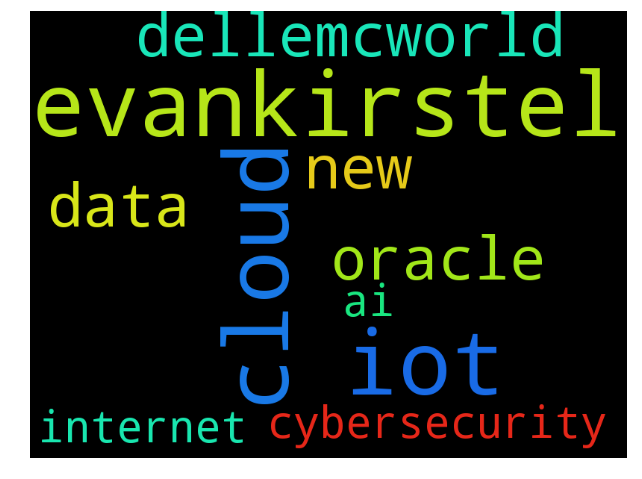

In [9]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
1491.3: evankirstel
635.1: iot
425.9: oracle
422.3: cloud
338.2: data
279.5: internet
239.4: new
218.3: things
189.2: 2016
188.6: microsoft
184.4: make
183.7: great
174.7: top
173.9: https
165.9: 10
163.3: datavail
154.6: analytics
153.1: google
145.5: https://t.…
140.8: one

Topic #1:
1840.4: evankirstel
1005.6: iot
630.9: dellemcworld
360.3: new
309.8: cloud
261.0: business
242.4: ai
240.1: cybersecurity
222.4: gartnersym
209.5: tech
207.0: dell
205.5: could
202.1: security
173.8: future
167.5: see
166.1: |
165.2: digital
155.8: bigdata
148.3: use
146.4: server



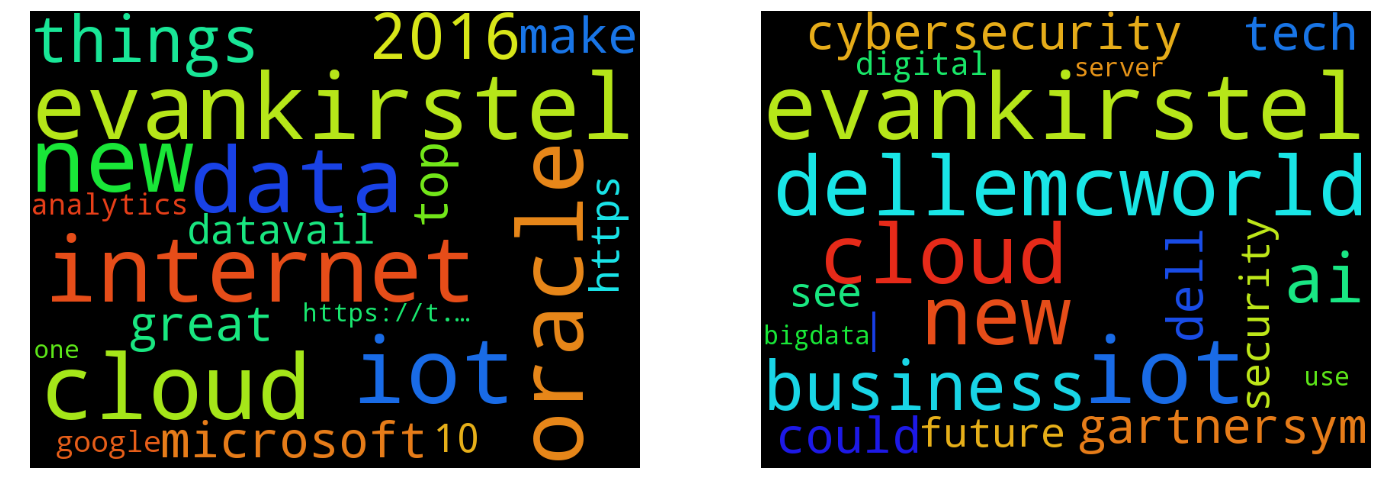

In [10]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
1119.4: evankirstel
647.1: iot
403.6: cloud
278.8: internet
263.0: oracle
232.1: top
218.3: things
188.4: microsoft
187.0: new
183.6: great
181.1: make
178.8: business
157.4: https
157.0: 10
153.7: data
134.0: it's
130.5: cybersecurity
127.2: know
126.4: bigdata
125.2: database

Topic #1:
1366.4: evankirstel
812.6: iot
631.0: dellemcworld
256.0: ai
217.3: new
206.8: dell
172.5: but
167.4: see
165.1: digital
160.8: future
160.0: tech
148.3: use
138.3: https://t.co…
134.8: could
124.5: technology
122.7: world
106.1: gartnersym
104.1: one
102.8: no
94.0: ‘

Topic #2:
845.8: evankirstel
266.9: cloud
229.7: server
216.6: cybersecurity
195.4: new
185.7: developerworks
180.9: iot
174.0: sql
166.1: oracle
159.8: datavail
159.6: data
141.4: ibm
139.3: using
132.8: find
130.7: sqlserver
119.1: |
118.1: “
110.2: power
107.3: check
105.5: ”



(0.0, 1.0, 0.0, 1.0)

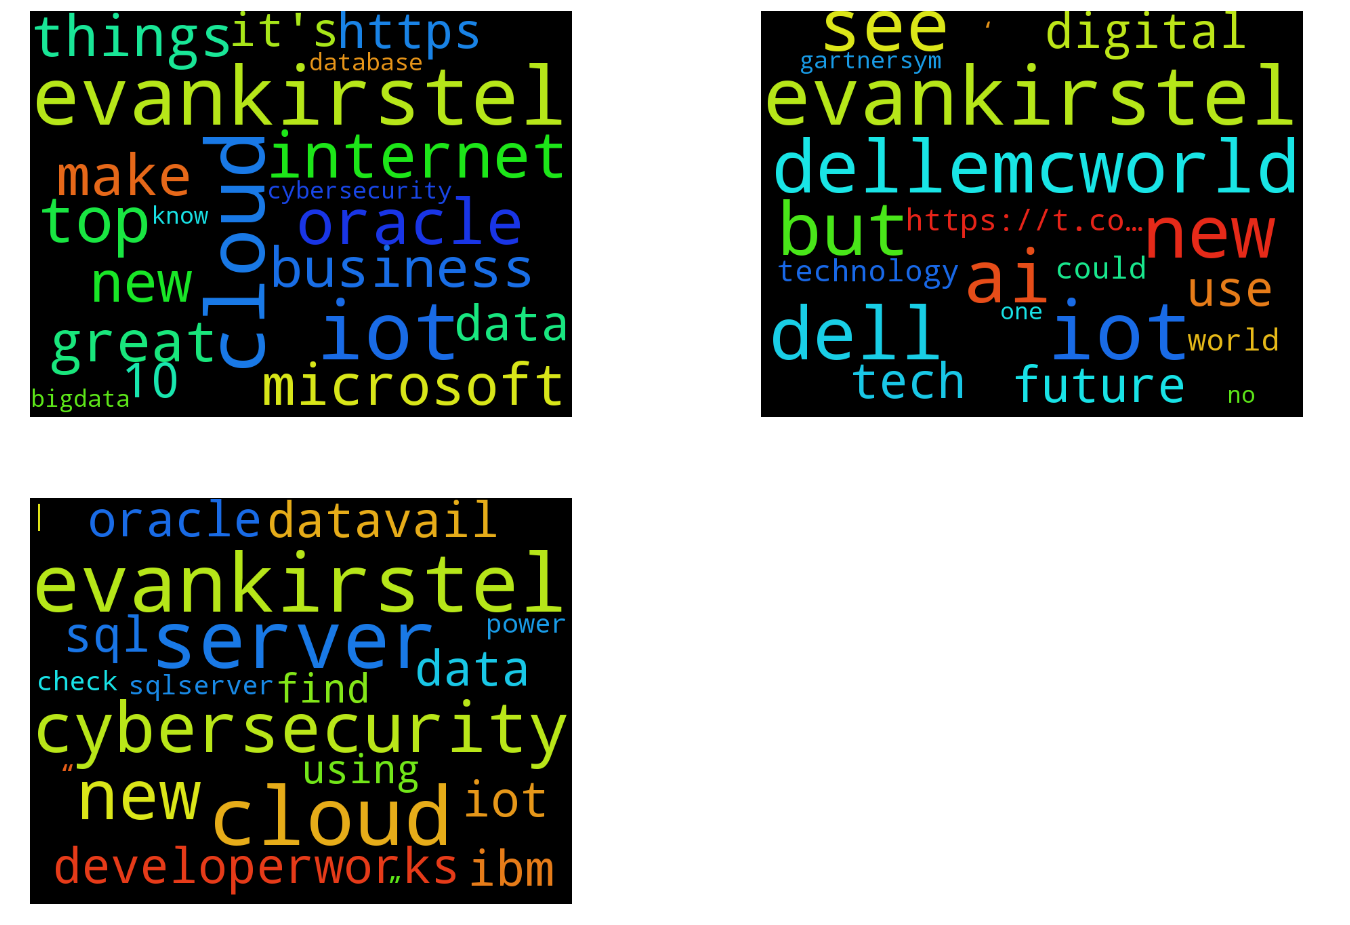

In [11]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
993.9: evankirstel
466.8: iot
342.0: cloud
226.7: internet
218.2: things
188.0: microsoft
186.6: 2016
159.6: https
144.2: oracle
134.0: it's
110.0: great
108.5: network
95.5: database
92.7: telecom
92.2: thanks
91.8: best
89.3: com
88.9: learn
88.7: time
84.2: want

Topic #1:
679.3: evankirstel
624.3: dellemcworld
418.1: iot
218.8: new
179.6: cloud
167.6: see
162.0: https://t.co…
159.6: dell
148.1: use
125.3: oracle
120.3: gartnersym
115.7: world
114.9: future
110.6: help
98.6: but
94.7: %
88.7: management
83.2: need
82.2: part
82.0: digital

Topic #2:
515.7: evankirstel
256.2: iot
229.6: server
201.2: data
182.0: bigdata
174.0: sql
159.9: oracle
148.9: cloud
148.3: datavail
139.3: using
136.7: analytics
130.7: sqlserver
118.1: “
113.7: ”
111.4: developerworks
110.3: power
107.9: |
105.6: blockchain
97.2: https://t.c…
93.3: ibm

Topic #3:
1142.8: evankirstel
499.6: iot
380.3: new
288.1: cybersecurity
279.4: ai
232.1: top
198.0: one
160.4: business
140.6: 10
136.7: security
11

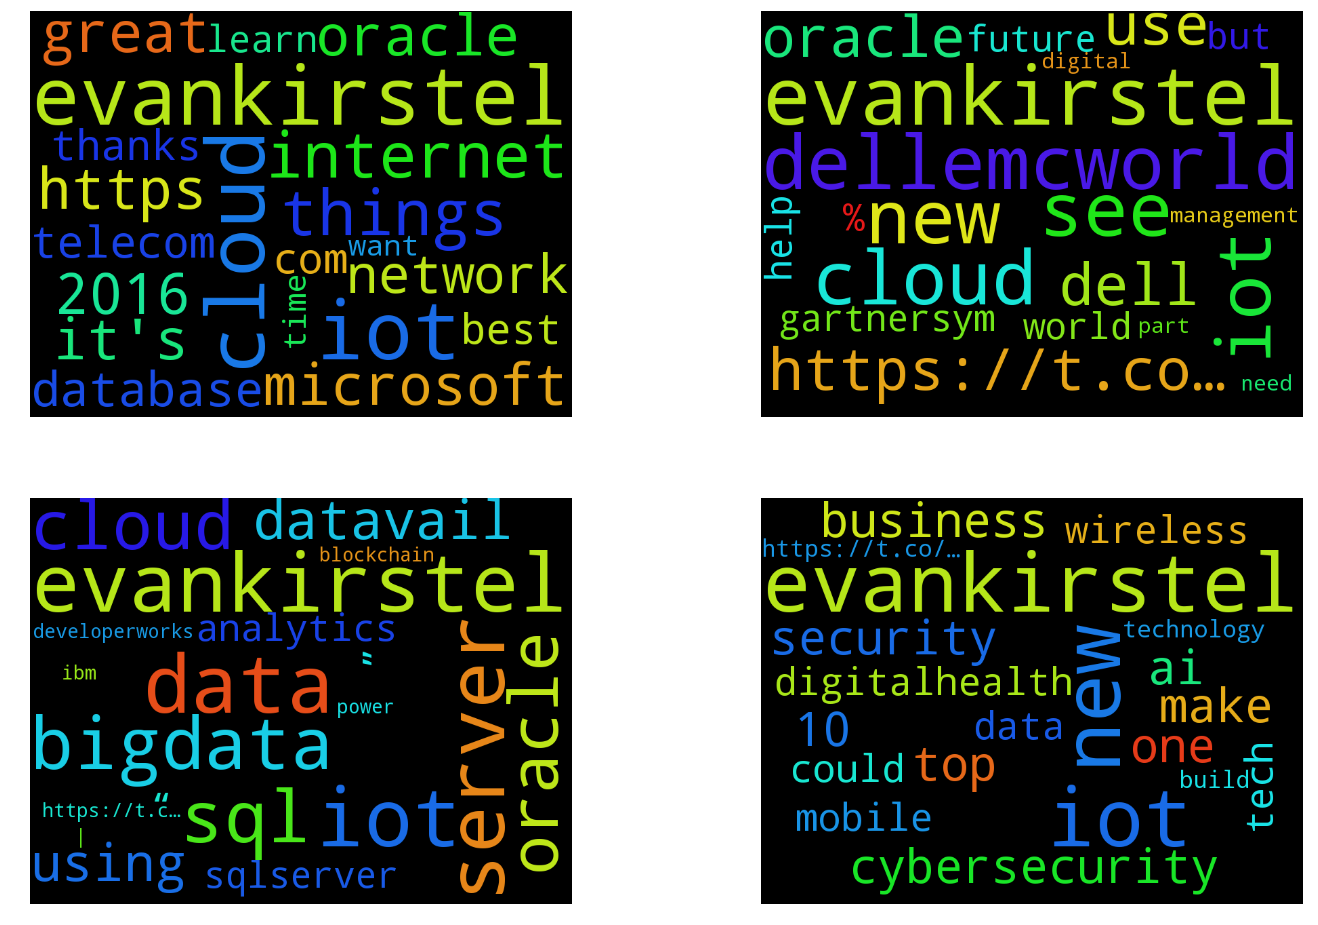

In [12]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

# Tweets in German

In [13]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train_de = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])

additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [14]:
X_train_de[-10:]

366    ThomasTeskeOrcl TWINT Swiss Mobile Payment bereit für Wachstum und Cloud mit Oracle 12c Mehr daz...
367          oraesque orclapex frankfurt meetup 2016-11- 18 17:00 Jetzt mit Agenda https://t.co/6A4TRLLUqr
368    DOAG2016 Schulungstag Multitenant Database Ob ich wohl etwas über die neue Version sagen darf Es...
369    IT_Connection Warum haben so wenige Unternehmen ein vernünftiges IT Sicherheitskonzept itsa16 it...
370          oraesque orclapex frankfurt meetup 2016-11- 18 17:00 Jetzt mit Agenda https://t.co/6A4TRLLUqr
371    ThomasTeskeOrcl TWINT Swiss Mobile Payment bereit für Wachstum und Cloud mit Oracle 12c Mehr daz...
372                                  IT_Connection prxpragma Micha_Schlede DAS ist auch mehr als notwendig
373    SchneiderElecDE FastData ist das neue Paradigma für IoT Lösungen IIoT Digitalisierung Innovation...
374    Eintracht Daumen hoch Marco Russ ist wieder gesund Die beste Nachricht 🔝 👍 🏼 👍 🏼 👍 🏼 sge eintrac...
375    Eintracht Kovac Marco Russ ist

In [15]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)
feature_names = vectorizer.get_feature_names()

In [16]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - German

Topic #0:
59.0: innovationateverylevel
47.7: cloud
47.5: it
36.2: it_connection
28.9: unternehmen
20.3: oracle
19.6: itsa16
19.6: 2016
17.5: datacenter
16.2: security



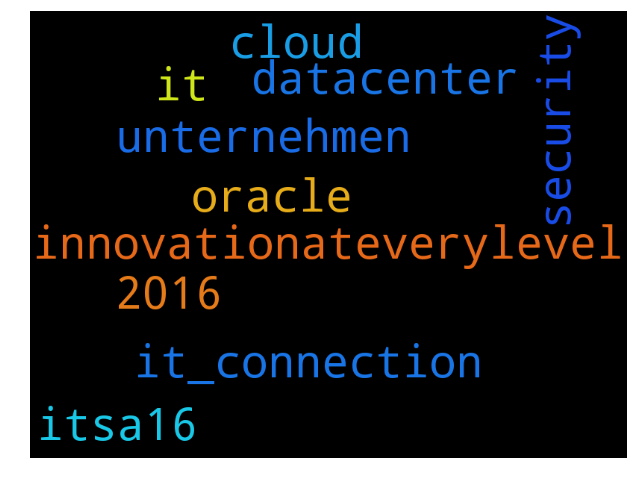

In [17]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

Topic #0:
58.4: innovationateverylevel
37.5: cloud
27.7: it
18.3: unternehmen
18.2: oracle
18.2: it_connection
17.1: itsa16
16.9: datacenter
15.7: security
13.9: schneiderelecde
13.8: 2016
12.6: deutschland
12.6: neue
11.5: mobile
11.5: iot
11.2: orclapex
10.7: oraclecloudday
10.2: stand
9.8: facebook
9.5: seforum16

Topic #1:
19.9: it
18.1: it_connection
12.0: https://t.co/sqraipeie8
11.1: nicht
10.6: unternehmen
10.2: cloud
8.1: micha_schlede
8.1: mercedes
7.8: nur
7.7: doag2016
7.6: https://t.co/e123z0upec
7.3: schützen
7.2: aber
7.0: on
7.0: •
7.0: reddit
7.0: https://t.co/kagwfk4gwu
7.0: r
7.0: uss
7.0: zumwalt



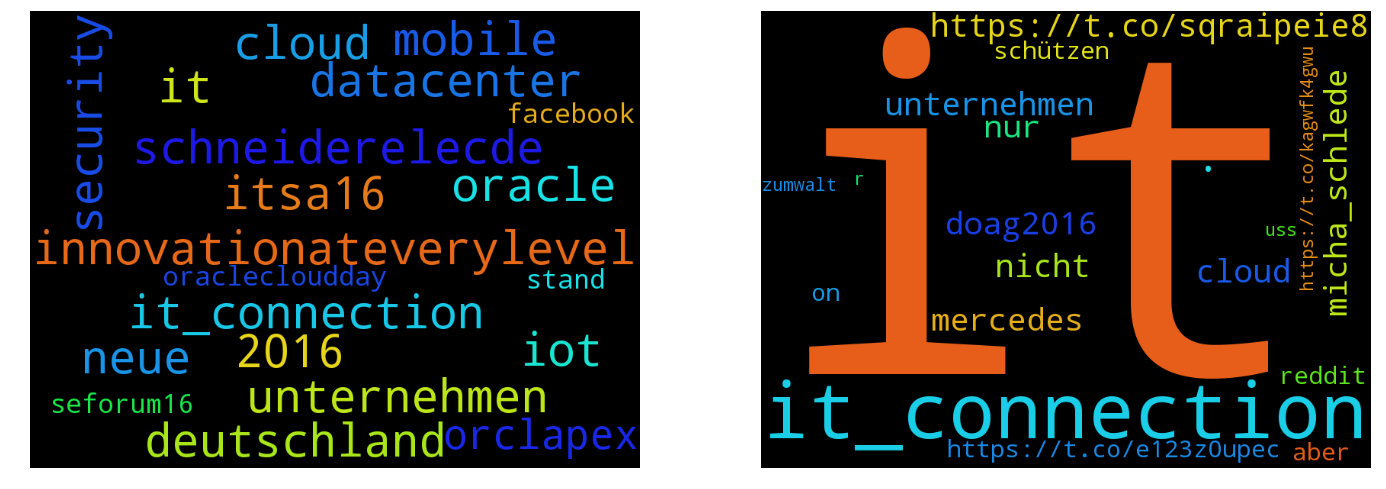

In [18]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

Topic #0:
47.7: innovationateverylevel
36.3: cloud
25.5: it
20.5: it_connection
18.5: unternehmen
15.5: security
15.2: neue
14.9: 2016
11.9: itsa16
11.9: datacenter
11.9: oracle
11.5: schneiderelecde
11.4: mobile
11.3: iot
11.1: orclapex
10.1: doag2016
9.7: facebook
9.3: seforum16
9.3: oraclecloudday
9.1: https://t.co/bcz8klxwav

Topic #1:
18.9: it
14.0: it_connection
11.9: https://t.co/sqraipeie8
8.8: unternehmen
8.2: nicht
7.5: nur
7.4: cloud
7.1: aber
6.5: https://t.co/e123z0upec
6.4: microsoft
5.2: schon
5.0: erfolgreich
4.7: micha_schlede
4.5: deutschland
4.5: richtige
4.5: infoblox
4.4: angriffe
4.4: strategie
4.4: 15:30
4.4: 26.10

Topic #2:
10.9: innovationateverylevel
7.7: evankirstel
7.2: fragen
6.9: uss
6.9: https://t.co/kagwfk4gwu
6.9: zumwalt
6.9: on
6.9: r
6.9: pics
6.9: https://t.co/uhqeebtew5
6.9: •
6.9: reddit
6.9: usnavy
6.6: doagev
6.2: https://t.co/5dzu6lmpkm
5.3: oracle
5.3: wurde
5.2: datacenter
5.2: sicherheit
5.1: google



(0.0, 1.0, 0.0, 1.0)

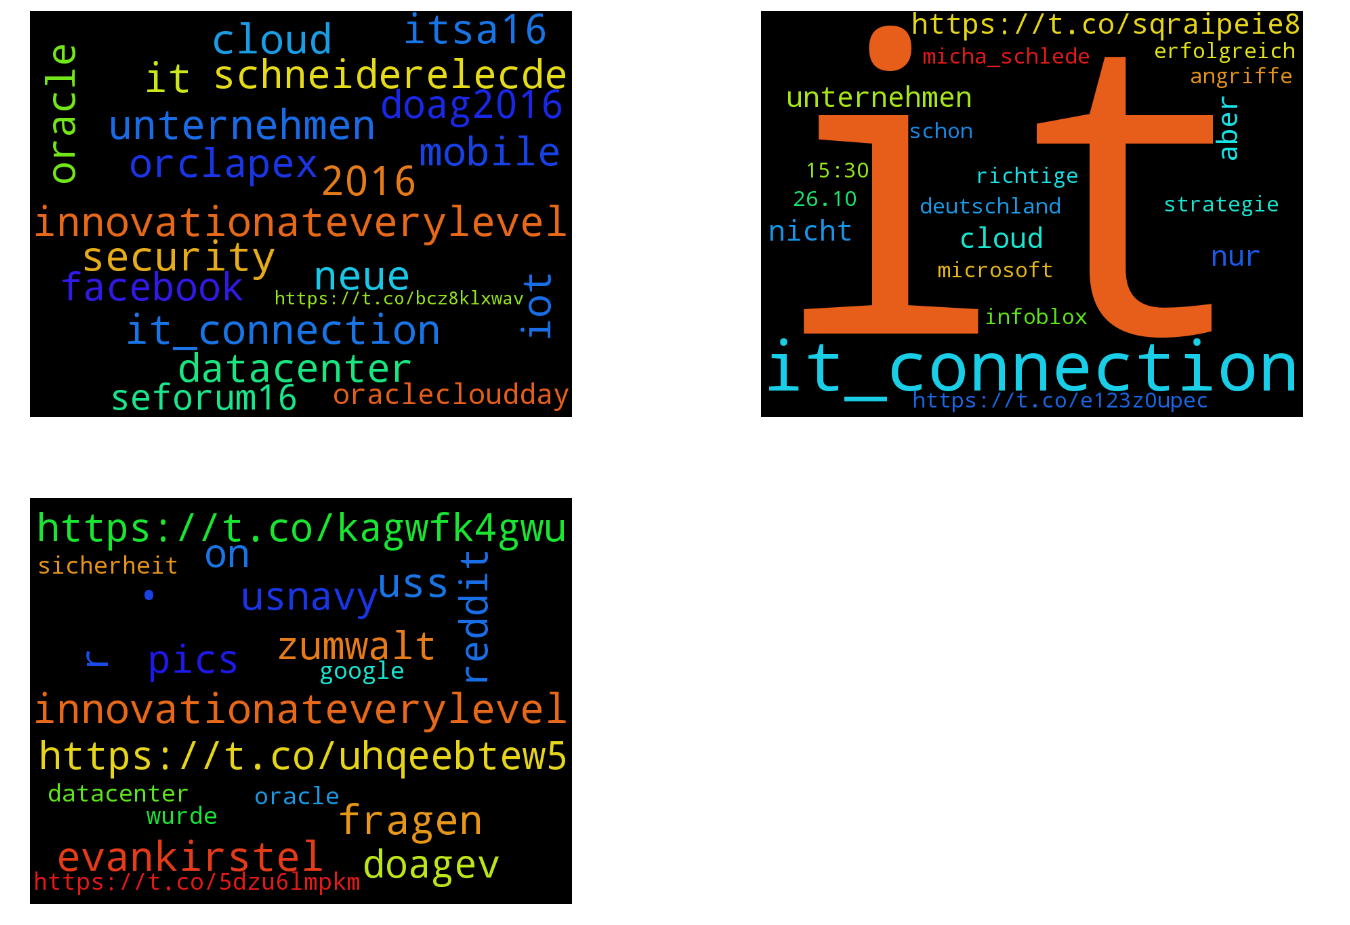

In [19]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - German

Topic #0:
48.7: innovationateverylevel
22.9: cloud
20.2: it
16.7: datacenter
14.3: it_connection
12.6: unternehmen
10.3: schneiderelecde
9.5: iot
9.3: neue
9.0: 2016
8.7: security
8.3: immer
8.2: seforum16
8.2: 👍
8.1: kampagnen
7.0: https://t.co/bcz8klxwav
6.4: digitalisierung
6.2: rechenzentrum
6.2: awareness
6.2: https://t.co/auqmreb9od

Topic #1:
18.9: it
12.9: it_connection
11.8: https://t.co/sqraipeie8
9.9: unternehmen
7.0: aber
6.8: nicht
6.5: itsa16
6.3: microsoft
5.1: schon
4.9: infoblox
4.1: innovationateverylevel
4.1: unterstützt
4.0: erfolgreich
4.0: bereits
4.0: infosec
3.9: nur
3.5: 👿
3.4: https://t.co/iqdpkc6twz
3.4: azure
3.3: kaspersky_dach

Topic #2:
10.5: deutschland
8.4: geht
6.2: s
5.9: https://t.co/5dzu6lmpkm
5.7: it_connection
5.4: azure
5.2: prxpragma
5.1: cloud
5.1: micha_schlede
4.9: ms
4.7: sicherheit
4.7: it
4.4: cloud-produktpalette
4.4: https://t.co/jmxi6zm828
4.4: übersicht
4.4: anmelden
4.4: oracle
4.4: expertenseminar
4.4: martinberger_ch
4.3: phishing



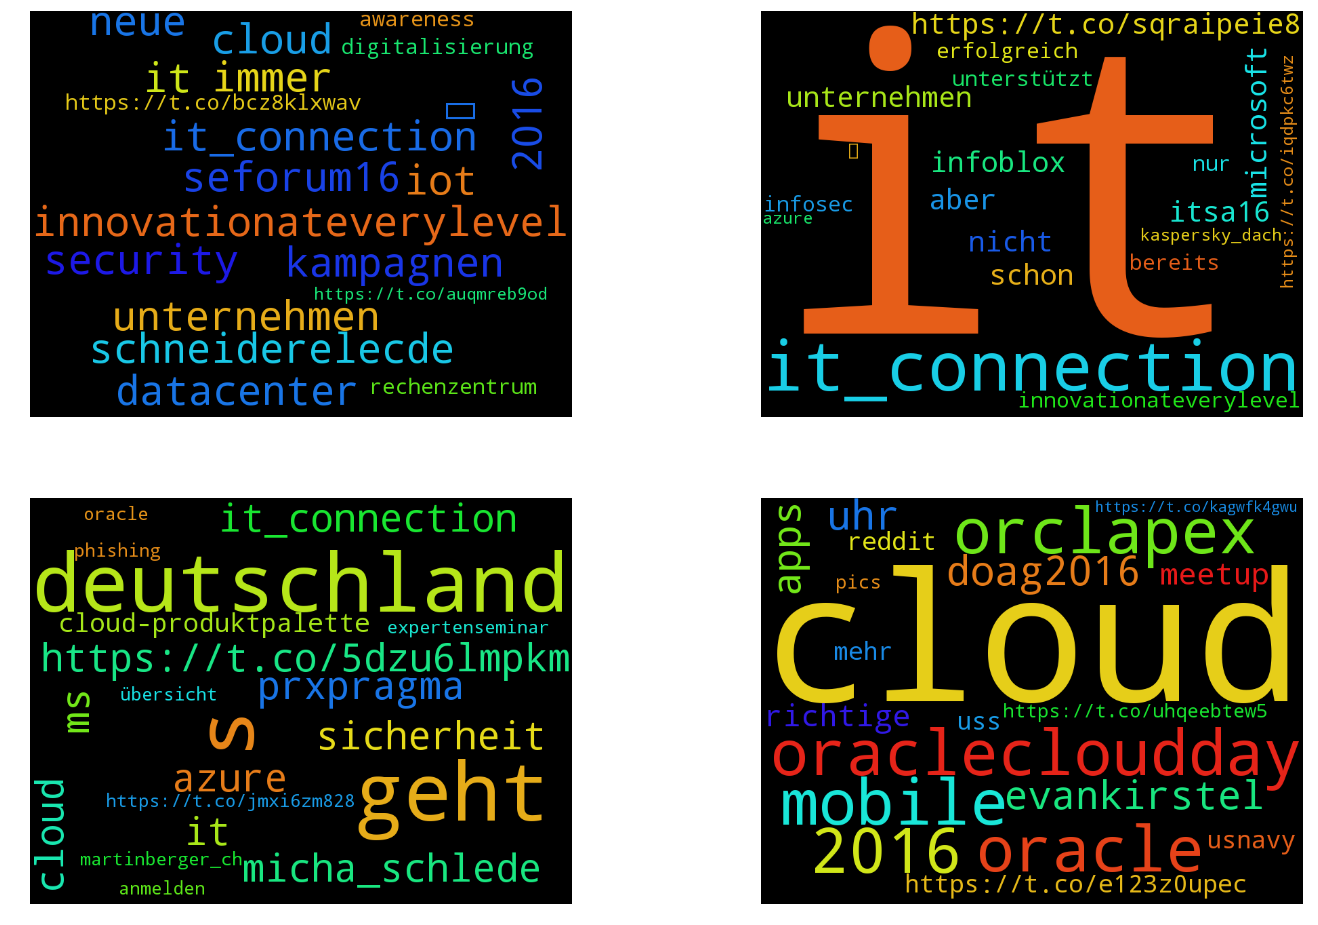

In [20]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

# Tweets in French

In [21]:
tweets_french = pd.read_csv(french_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_french['text_wo_#'] = tweets_french['text_processed'].apply(lambda x: remove_hash(x))
tweets_french['text_wo_#@'] = tweets_french['text_wo_#'].apply(lambda x: remove_at(x))

X_train_fr = tweets_french['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [22]:
X_train_fr[-10:]

146    ProustNicolas Pourquoi le DSI ne doit pas être laissé dans l'ignorance Par DavidDariouch https:/...
147    ProustNicolas Pourquoi le DSI ne doit pas être laissé dans l'ignorance Par DavidDariouch https:/...
148                      FAOnews lemondefr sauf que cette fois les chasseurs-cueilleurs seront des snipers
149    lemondefr ESA_ExoMars avec la pression venue de l'Asie il faut a tour prix accelerer les projets...
150    informatique Bretagne Finistère Découvrez une solution de virtualisation de serveur Linux peu co...
151    j_thersen Aprem studieuse aux JMI avec la présentation du métier de DBA aux étudiants de polytec...
152    j_thersen Le DBA devient dataOps avec l'avènement du BigData JMI as2i Claranet polytech lille ru...
153    ProustNicolas Pourquoi le DSI ne doit pas être laissé dans l'ignorance Par DavidDariouch https:/...
154    Novirent serveurs informatique est sorti de presse https://t.co/TUATaF7xEM Les unes d'aujourd'hu...
155    ProustNicolas Pourquoi le DSI 

In [23]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)
feature_names = vectorizer.get_feature_names()

In [24]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - French

Topic #0:
18.4: pourquoi
16.2: dsi
16.2: être
15.7: cloud
14.6: daviddariouch
14.6: laissé
14.6: doit
14.6: https://t.co/axg3iczrgy
14.6: l'ignorance
14.1: proustnicolas



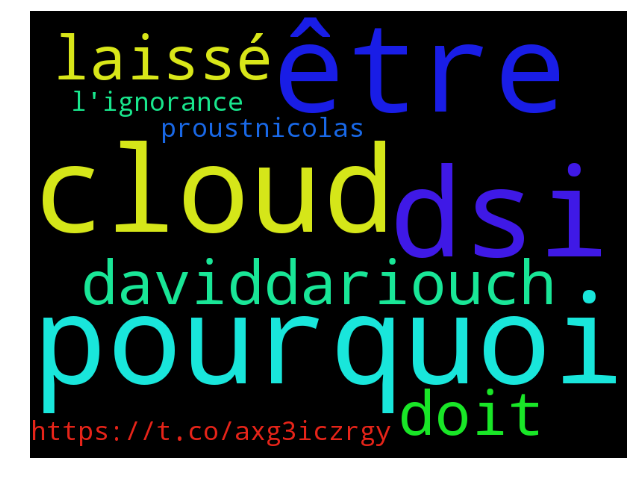

In [25]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

Topic #0:
15.7: dsi
15.4: pourquoi
15.4: être
15.1: cloud
14.1: daviddariouch
14.1: laissé
14.1: doit
14.1: https://t.co/axg3iczrgy
14.1: l'ignorance
13.6: proustnicolas
9.2: recrutement
7.1: informatique
7.0: première
6.5: welovestartups
6.4: apple
6.1: day
6.1: comment
6.0: oracle_france
6.0: français
5.9: reconnaître

Topic #1:
7.0: lille
6.4: lemondefr
6.0: a
6.0: jmi
6.0: j_thersen
5.9: polytech
5.9: as2i
5.9: dba
5.9: ..
5.9: atlantico_fr
5.9: e
5.3: informatique
4.7: transfodigitale
4.4: comme
4.3: point
4.3: faisons
4.3: ensemble
4.3: gagner
4.3: enquête
4.3: https://t.co/u8sev1dktg



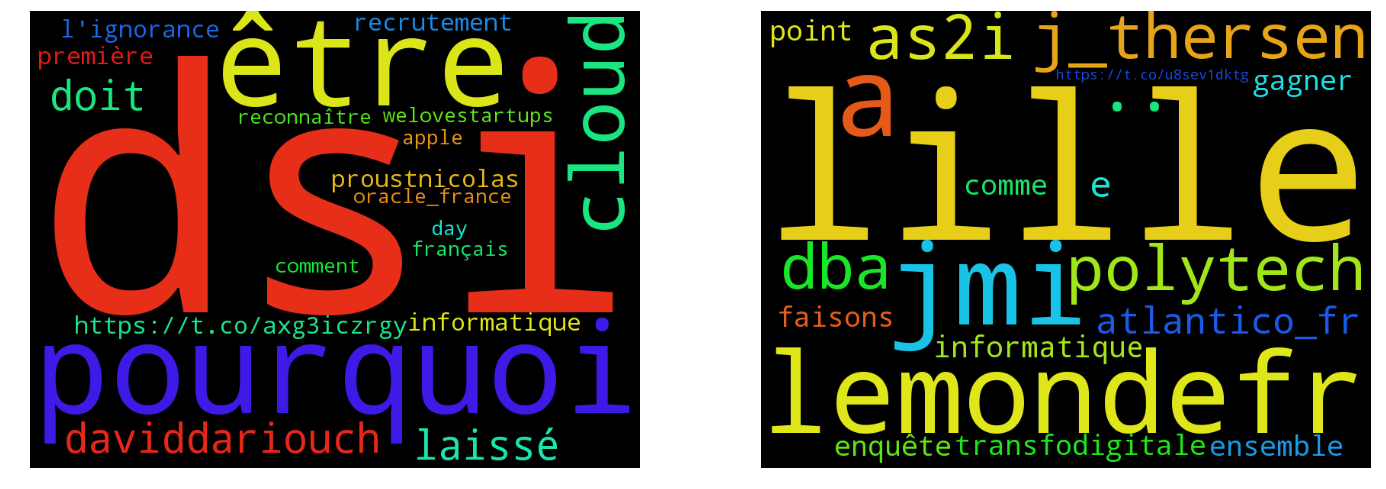

In [26]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

Topic #0:
15.3: dsi
14.4: pourquoi
13.9: cloud
13.9: être
13.9: daviddariouch
13.9: laissé
13.9: doit
13.9: https://t.co/axg3iczrgy
13.9: l'ignorance
13.3: proustnicolas
9.1: recrutement
7.4: informatique
6.9: première
6.4: welovestartups
6.4: day
6.4: apple
5.8: oracle_france
5.8: fera
5.8: https://t.co/1ggkwcof9h
5.8: exposants

Topic #1:
5.8: a
4.3: transfodigitale
4.2: point
4.2: ensemble
4.2: faisons
4.2: gagner
4.2: https://t.co/u8sev1dktg
4.2: enquête
4.2: tablette
3.7: pourquoi
3.7: comme
3.6: faut
3.6: ia
3.5: projets
3.2: lemondefr
3.1: gouvernement
3.1: sentent
3.1: rare
3.1: pression
3.1: fonctionnels

Topic #2:
6.8: lille
5.8: e
5.8: français
5.8: reconnaître
5.8: dba
5.8: polytech
5.8: jmi
5.8: j_thersen
5.8: as2i
4.7: informatique
4.2: article
4.2: https://…
4.2: crm
4.2: 1
3.7: presse
3.6: fois
3.6: entreprises
3.6: iot
3.6: |
3.6: runiso



(0.0, 1.0, 0.0, 1.0)

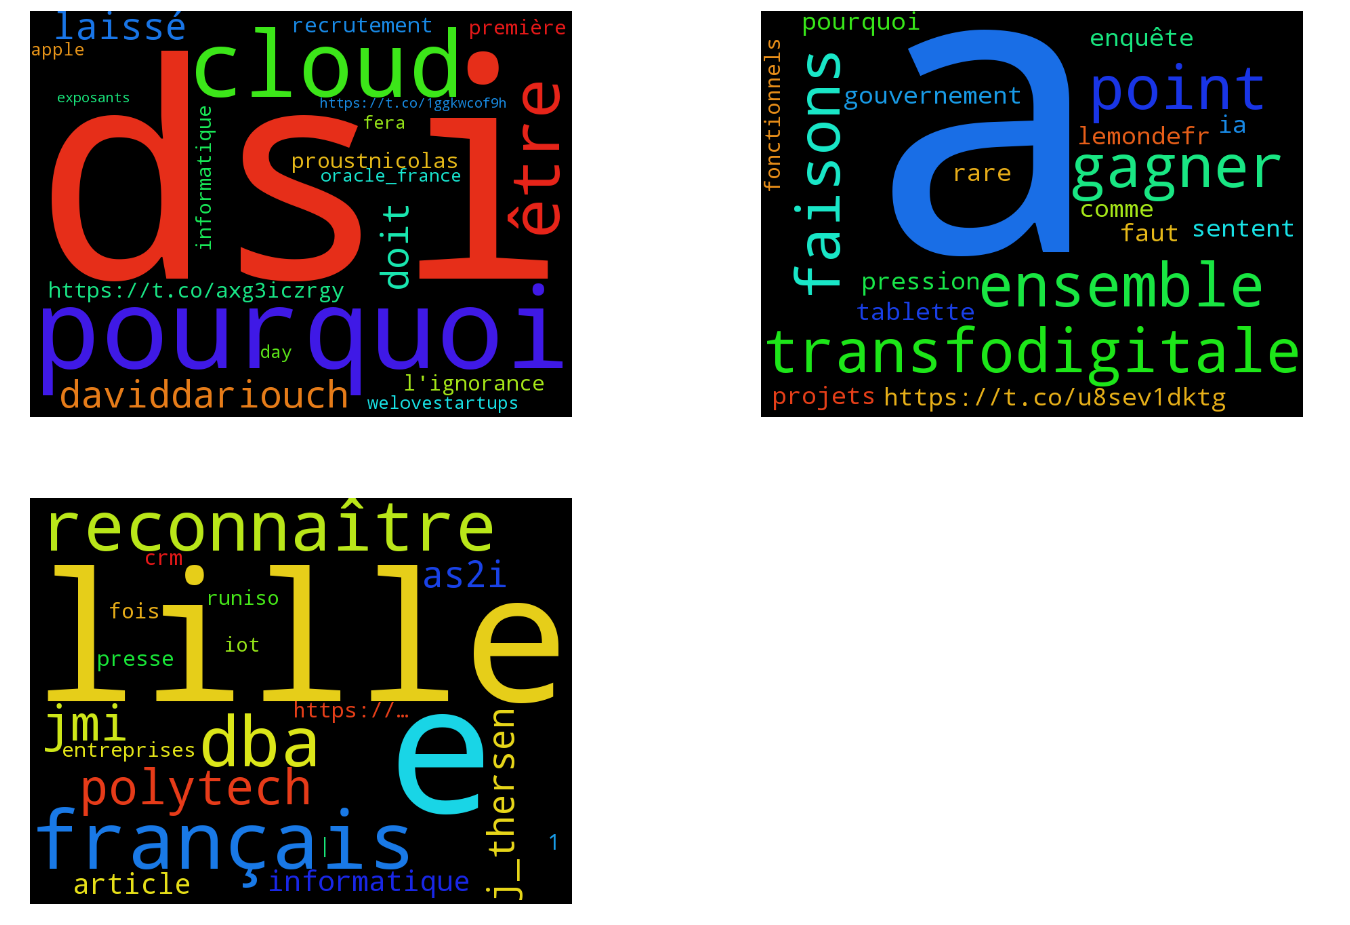

In [27]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - French

Topic #0:
15.3: dsi
14.4: pourquoi
13.9: daviddariouch
13.9: laissé
13.9: cloud
13.8: doit
13.8: être
13.8: https://t.co/axg3iczrgy
13.8: l'ignorance
13.0: proustnicolas
9.0: recrutement
6.8: première
6.3: apple
5.7: fera
5.7: exposants
5.7: https://t.co/1ggkwcof9h
5.7: mwc
5.7: partie
5.2: welovestartups
5.2: oracle_france

Topic #1:
4.7: a
4.1: point
4.1: ensemble
4.1: faisons
4.1: transfodigitale
4.1: gagner
4.1: https://t.co/u8sev1dktg
4.1: enquête
4.1: tablette
3.6: comme
3.6: pourquoi
3.6: faut
3.6: ia
3.0: projets
3.0: lemondefr
3.0: rare
3.0: gouvernement
3.0: fonctionnels
3.0: sentent
3.0: pression

Topic #2:
5.7: e
5.7: français
5.7: reconnaître
4.1: lille
4.1: article
4.1: https://…
4.1: 1
3.6: fois
3.6: presse
3.6: runiso
3.6: claranet
3.6: cette
3.5: flashtweet
3.0: comment
3.0: lemondefr
3.0: surcoté
3.0: pourtant
3.0: dataops
3.0: publiques
3.0: l'avènement

Topic #3:
9.6: informatique
4.1: sorti
4.1: d'aujourd'hui
4.1: novirent
4.1: unes
4.1: presse
4.1: crm
4.1: serveu

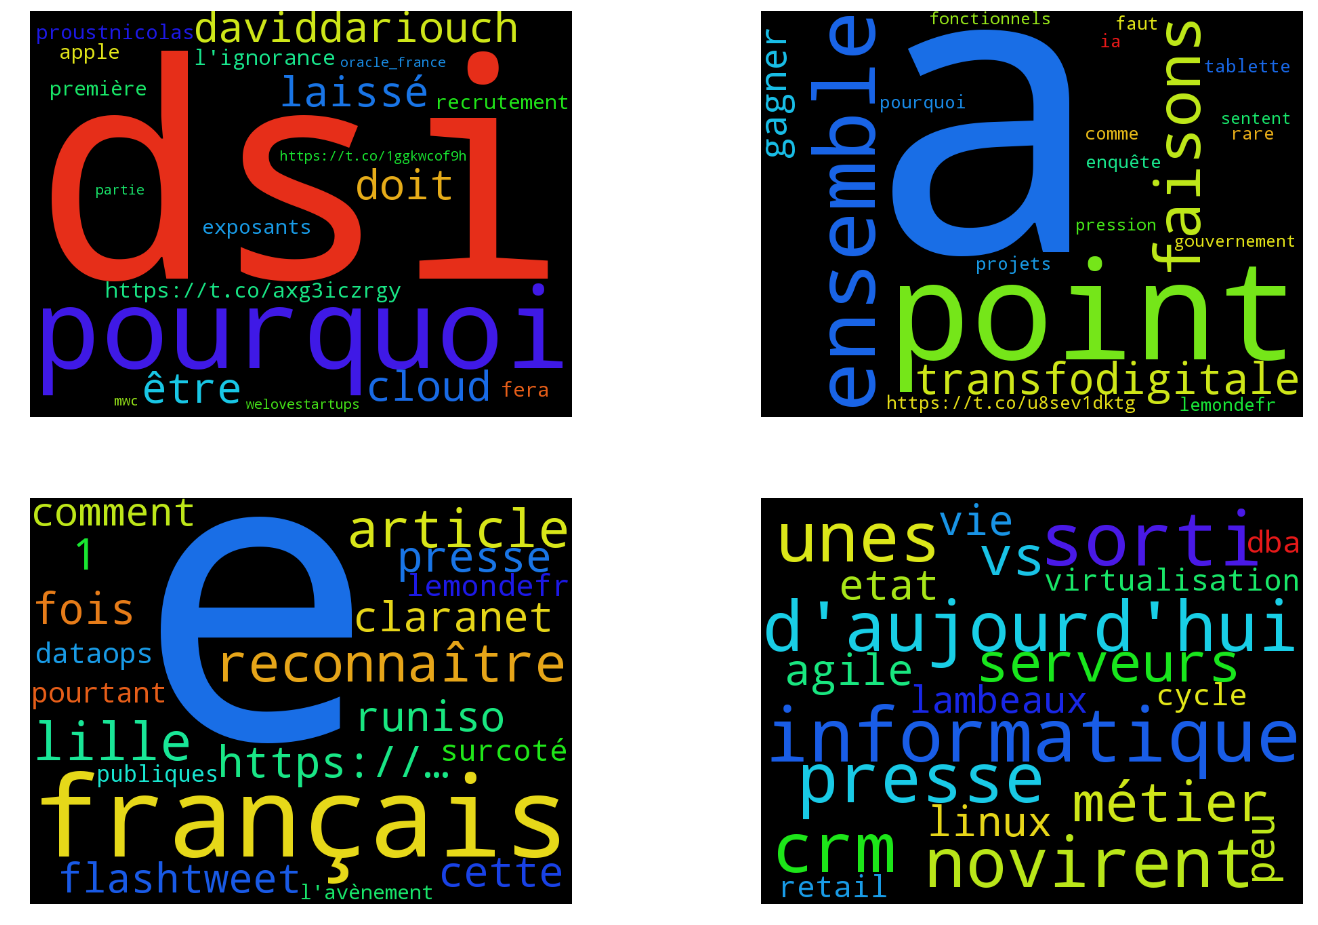

In [28]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)